# The Standard PT Model

In [1]:
from prepare import *
ecs=equalize_and_compress_and_sort


current path C:\Users\aes05kgb\Kelvin\Kel1\Risk\Stan2


# The core Stan Code is below

In [2]:
function=  """
  functions   //A fuction which returns a number between 0 and 1 given a number than might step outside of the bounds
    {
     real makep(real p)
        {real q;
           {if (p<=0)
               q=10^-12;
            else
               {if (p>=1)
                  q=1;
                else
                  q=p;
               }
            }
         return q;  
        }
    
    real uf(real x,real alpha,real beta,real lamda) //the utility functiton
        { real z;
            {if (x>=0)
                z=(fabs(x)^alpha);
             else
                z=-lamda*(fabs(x)^beta);
            }
        return z;    
        }
        
    real iuf(real x,real alpha,real beta,real lamda) //the inverse utility function
        { real z;
            {if (x>=0)
                z=fabs(x)^(1/alpha);
             else
                z=-((fabs(x)/lamda)^(1/beta));
            }
        return z;    
        }    
        
    real pf(real p,real alpha,real beta)             // probability weighting function
        {real z; real h;
               { h=makep(p);
                 z=exp(-beta*(((-log(h))^alpha)));
            } 
        return z;    
        }  
    vector vpf(vector p,int N,real alpha,real beta)  //vector probability weighting funciton
        {
         vector[N] z; 
         for(i in 1:N) 
            {
            z[i]=pf(p[i],alpha,beta);
            } 
        return z;
        }    
    vector vuf(vector x,int N,real alpha,real beta,real lamda)  //vector utility function
        {
        vector[N] z; 
        for(i in 1:N) 
            {
            z[i]=uf(x[i],alpha,beta,lamda);
            } 
        return z;
        }
    real evf(vector x,int N,vector w, vector W)             //expected value function
        {
        real z;
        z=0;
        for(i in 1:N) 
            {if (x[i]>=0)
                z=z+w[i]*x[i];
             else
                z=z+W[i]*x[i];
            } 
        return z;
        }  
     vector adcf(vector p,int N)                              //anti-decumulative function
        {
        vector[N] z; int i;
        for(j in 1:N) 
            {i=N-j+1;
            if (i==N)
                z[i]=p[i];
            else
                z[i]=p[i]-p[i+1];
            } 
        return z;
        }
      vector acf(vector p,int N)                               //anti-cumulative function
        {
        vector[N] z; 
        for(i in 1:N) 
            {
            if (i==1)
                z[i]=p[i];
            else
                z[i]=p[i]-p[i-1];
            } 
        return z;
        }  
    }

data {int typ;              //positive if utility model else uses certainty equivalents
       int N;               //Number of payoffs in each lottery
       int M;               //Number of Choices made by each individual (must be same for all)
       int T;               //Number of people 
       int y[T,M];          //The choices, 1 for option A, 2 for B 
       
       vector[N] xA[T,M];   //Payoffs for option A
       vector[N] xB[T,M];   //Payoffs for option B
       vector[N] FA[T,M];   //Decumulative Distributions for option A
       vector[N] PA[T,M];   //Cumulative Distributions for option A
       vector[N] FB[T,M];   //Decumulative Distributions for option B
       vector[N] PB[T,M];   //Cumulative Distributions for option B
       
       
       //The following are the prior means for the mean parameters
       //For alpha,beta,lambda, gammas and deltas these can be =1, m_scale=1 is also ok
       real m_alpha;                         //Power for value function in the gain doman
       real m_beta;                          //Power for value function in the loss doman
       real m_lamda;                         // Loss Aversion Coefficient
       real m_gama1;   real m_gama2;         //probability weightings Gain Domain (for Prelec II)
       real m_delta1;  real m_delta2;        //probability weightings Gain Domain (for Prelec II)
       real m_scale;                         //Mean noise for the scale parameter, this is the log of the scale 
       
       //The following are the piror standard deviation parameters for the mean parameters, notation as directly above 
       //Standard deviations or aroud 1/2 or less work well, though scale can be set bigger e.g. 3
       real s_alpha;
       real s_beta;
       real s_lamda; 
       real s_gama1; real s_gama2;
       real s_delta1;real s_delta2; 
       real s_scale;
       
       #These are the settings for the gamma distributions for alpha, beta, gammas and deltas
       real ga; real gb;
       
       int Domain[T,M];    //Specify the Domain of the Choice, 1 for gain, 2 for Loss and 3 for mixed
       }

parameters{//The mean parameters
           real<lower=0.05,upper=1.90> alpha;  //Power Utility in the Gain Domain
           real<lower=0.05,upper=1.90> beta;   //Power Utility in the Loss Domain
           real<lower=0.05,upper=4.90> lamda;  //Loss Aversion Parameter
           
           real<lower=0.5,upper=1.9> gama1;    //Prelec II probability Weightings Gain Domain
           real<lower=0.5,upper=1.9> gama2; 
           
           real<lower=0.5,upper=1.9> delta1;   //Prelec II probability Weightings Loss Domain
           real<lower=0.5,upper=1.9> delta2;
           
           real<lower=-2,  upper=2>scale[3];   //Log Scale parameter for differences in error variance across domains
           
           
           //The parameters for individuals, definitions above underscore differentiates individual from overall mean
           //Limits below can be set wider but contain consensus regions
           //Note that these should be wider than the limits set for the mean parameters
           real<lower=0.01,upper=2> alpha_[T]; 
           real<lower=0.01,upper=2> beta_[T]; 
           real<lower=0.01,upper=5> lamda_[T];
           real<lower=0.4,upper=2> gama1_[T]; 
           real<lower=0.4,upper=2> gama2_[T];
           real<lower=0.4,upper=2> delta1_[T]; 
           real<lower=0.4,upper=2> delta2_[T];
           real<lower=-2.5,  upper=2.5> scale_[T,3];
           
           //Precision Parameters for the Hierachical Distributions (governing the parameters for individuals)
            real<lower=0.001,upper=100> p_alpha;
            real<lower=0.001,upper=100> p_beta;
            real<lower=0.001,upper=100> p_lamda; 
            real<lower=0.001,upper=100> p_gama1;
            real<lower=0.001,upper=100> p_gama2;
            real<lower=0.001,upper=100> p_delta1; 
            real<lower=0.001,upper=100> p_delta2; 
            real<lower=0.001,upper=100> p_scale;
       }
           
//The transformed parameters are below
//While these are declared directly below, their definitions follow within the transformed parameters block

transformed parameters {vector[N] vA[T,M]; vector[N] vB[T,M];
                        vector[N] FA_[T,M];vector[N] PA_[T,M]; 
                        vector[N] FB_[T,M];vector[N] PB_[T,M];  
                        vector[N] WFA[T,M]; vector[N] WPA[T,M];
                        vector[N] WFB[T,M]; vector[N] WPB[T,M];
                        //vector[N] prA[T,M];vector[N] prB[T,M];
                        
                        real evA_[T,M]; 
                        real evB_[T,M]; 
                        real euA_[T,M]; 
                        real euB_[T,M]; 
                        real CEA_[T,M];  
                        real CEB_[T,M];
                        
                        vector[2] MU[T,M];
                        
                        //Converting the precisions to standard deviations
                        real sd_alpha=1/sqrt(p_alpha);
                        real sd_beta=1/sqrt(p_beta);
                        real sd_lamda=1/sqrt(p_lamda);
                        real sd_gama1=1/sqrt(p_gama1);
                        real sd_gama2=1/sqrt(p_gama2);
                        real sd_delta1=1/sqrt(p_delta1); 
                        real sd_delta2=1/sqrt(p_delta2); 
                        real sd_scale=1/sqrt(p_scale);
                        
                        //real evA[T,M]; 
                        //real evB[T,M]; 
                        //real euA[T,M]; 
                        //real euB[T,M]; 
                        //real CEA[T,M];  
                        //real CEB[T,M];
                        
                       
                        for (t in 1:T)
                        {
                        for (i in  1:M){
                        vA[t,i]=vuf(xA[t,i],N,alpha_[t],beta_[t],lamda_[t]);  //vector of utilities option A
                        vB[t,i]=vuf(xB[t,i],N,alpha_[t],beta_[t],lamda_[t]);  //vector of utilities option B
                        
                        PA_[t,i]=vpf(PA[t,i],N,delta1_[t],delta2_[t]);        //cumulative transformed A
                        FA_[t,i]=vpf(FA[t,i],N,gama1_[t],gama2_[t]);          //decumulative transformed A
                        
                        PB_[t,i]=vpf(PB[t,i],N,delta1_[t],delta2_[t]);         //cumulative transformed B
                        FB_[t,i]=vpf(FB[t,i],N,gama1_[t],gama2_[t]);           //decumulative transformed B
                               
                        WPA[t,i]=acf(PA_[t,i],N);                              //weights loss domain A
                        WFA[t,i]=adcf(FA_[t,i],N);                             //weights gain domain A
                        
                        WPB[t,i]=acf(PB_[t,i],N);                              //weights loss domain B
                        WFB[t,i]=adcf(FB_[t,i],N);                             //weights gain domain B
                        
                        euA_[t,i]=evf(vA[t,i],N,WFA[t,i],WPA[t,i]);           // PT expected utility A
                        euB_[t,i]=evf(vB[t,i],N,WFB[t,i],WPB[t,i]);            // PT expected utility B
                        
                        //Can sample other quantities but little point if running PT model, have left this in but edited out                      
                        //prA[t,i]=adcf(FA[t,i],N);                            // Lottery Probabilities
                        //prB[t,i]=adcf(FB[t,i],N);                            // Lottery Probabilities
                        
                        //evA[t,i]=evf(xA[t,i],N,prA[t,i],prA[t,i]);            // The expected value 
                        //evB[t,i]=evf(xB[t,i],N,prB[t,i],prB[t,i]);            // The expected value 
                        
                        evA_[t,i]=evf(xA[t,i],N,WFA[t,i],WPA[t,i]);             // Expected Value of A based on PT weights
                        evB_[t,i]=evf(xB[t,i],N,WFB[t,i],WPB[t,i]);             // Expected Value of B based on PT weights
                        
                        //euA[t,i]=evf(vA[t,i],N,prA[t,i],prA[t,i]);              // The expected utility of A (untransformed probs)
                        //euB[t,i]=evf(vB[t,i],N,prB[t,i],prB[t,i]);              // The expected utility of B (unbransformed probs)
                        
                                                                                   //CE=Certainty Equivalent
                        //CEA[t,i]=iuf(euA[t,i],alpha_[t],beta_[t],lamda_[t]);     // CE under Expected Utility     
                        //CEB[t,i]=iuf(euB[t,i],alpha_[t],beta_[t],lamda_[t]);     // CE under Expected Utility     
                        
                        CEA_[t,i]=iuf(euA_[t,i],alpha_[t],beta_[t],lamda_[t]);     // CE under PT
                        CEB_[t,i]=iuf(euB_[t,i],alpha_[t],beta_[t],lamda_[t]);     // CE under PT 
 
                         if (typ<0)                                     //Do Certainty Equivalent model
                            {MU[t][i,1]=CEA_[t,i]; 
                             MU[t][i,2]=CEB_[t,i];}                
                        else                                            //Do Utility model
                            {MU[t][i,1]=euA_[t,i]; 
                             MU[t][i,2]=euB_[t,i];}              
                        
                                      }           
                        
                        }
                        }
                                               
model {
     //The priors for the parameters are set out below
       alpha~normal(m_alpha,s_alpha);     
       beta~normal(m_beta,s_beta);        
       lamda~normal(m_lamda,s_lamda);     
       gama1~normal(m_gama1,s_gama1);     
       gama2~normal(m_gama2,s_gama2);     
       delta1~normal(m_delta1,s_delta1);  
       delta2~normal(m_delta2,s_delta2); 
     
       
       p_alpha~gamma(ga,gb);
       p_beta~gamma(ga,gb);
       p_lamda~gamma(ga,gb);
       p_gama1~gamma(ga,gb);
       p_gama2~gamma(ga,gb);
       p_delta1~gamma(ga,gb); 
       p_delta2~gamma(ga,gb); 
       p_scale~gamma(1,1);
       for (j in 1:3){scale[j]~normal(m_scale,s_scale); }
       
       for(t in 1:T)
             {  
              alpha_[t]~normal(alpha,sd_alpha);
              beta_[t]~normal(beta,sd_beta);
              lamda_[t]~normal(lamda,sd_lamda);
              gama1_[t]~normal(gama1,sd_gama1);
              gama2_[t]~normal(gama2,sd_gama2);
              delta1_[t]~normal(delta1,sd_delta1);
              delta2_[t]~normal(delta2,sd_delta2);
              
              for (j in 1:3){ scale_[t,j]~normal(scale[j],sd_scale);}  
               
              for(i in 1:M) {  
                                y[t,i] ~ categorical_logit(exp(scale_[t,Domain[t,i]])*MU[t][i]);
                             }
              }
              
              
      }
      
generated quantities {vector[T*M] log_lik; int j;
                        j=1;    
                        for (t in 1:T) {
                            for (i in 1:M) {
                                      log_lik[j] =log_softmax(exp(scale_[t,Domain[t,i]])*MU[t][i])[y[t,i]];
                                      j=j+1;
                                          }
                                        }
                     } 
"""

In [3]:
#Compile the model, Note thatif you have previously compiled it you can use the loadmodel command so as not to recompile
#sm = pystan.StanModel(model_code=function)

In [4]:
#Save the compiled code
#savemodel(sm,'modelbasic')

In [5]:
#Load the compiled code
sm=loadmodel('modelbasic')

In [6]:
#The data contains 14300 rows and 45 columns, it has different treatments etc but we will not use these
dat=pd.read_excel('Fulldata3.xlsx')

In [7]:
#Create a variable specifying the domain of the gamble as 1,2,3 below
dat['Dom']=(dat['Gains']==1)*1+(dat['Loss']==1)*2+(dat['Mixed']==1)*3

#All lotteries have up to three payoffs. However, there are missing values that should be given zeros
xA=twodma(dat[['prize1l','prize2l','prize3l']].fillna(0))
pA=twodma(dat[['p1left','p2left','p3left']].fillna(0))
pA=pA/sumc(pA.T)
xB=twodma(dat[['prize1r','prize2r','prize3r']].fillna(0))
pB=twodma(dat[['p1right','p2right','p3right']].fillna(0))
pB=pB/sumc(pB.T)

#The lotteries are not ordered and can contain repeated values, 
#The ecs function (written in python) compressess them into unique value and orders 
xA_,pA_=ecs(xA,pA)
xB_,pB_=ecs(xB,pB)

#Create the cumulative and decumulative vectors for options A and B
PA=cumdist(pA_)
FA=dcumdist(pA_)
PB=cumdist(pB_)
FB=dcumdist(pB_)

Y=array(-dat['choices']+2) #relabel the choices 1 for A and 2 for B, originally 0 and 1
DOM=array(dat['Dom'])
ideas=sorted(list(set(dat['id'])))

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [8]:
#Now create the arrays that can be read in a format that can be put into STAN
#The dimensions will match that in the Stan Code
y,xa,xb,fa,fb,pa,pb,dom=[],[],[],[],[],[],[],[]


M=100  #The number of tasks performed by each person

#Data is organised into responses by individuals
j=0
for i in ideas:
    y+=[Y[j:j+M]]      #The Choices
    xa+=[xA_[j:j+M,:]] #Lottery A Payoffs
    xb+=[xB_[j:j+M,:]] #Lottery B Payoffs
    fa+=[FA[j:j+M,:]]  #DeCumulative distribution for A
    fb+=[FB[j:j+M,:]]  #DeCumulative distribution for B
    pa+=[PA[j:j+M,:]]  #Cumulative distribution for A 
    pb+=[PB[j:j+M,:]]  #Cumulative distribution for B
    dom+=[DOM[j:j+M]]  #Specify the domain of the lottery
    j=j+M
    #print(j,j+M,rows(xA_[j:j+M,:]))
    
N=3           #The potential number of payoffs
T=len(ideas)  #The number of people

In [9]:
#You can see the dimensions here
[shape(y),shape(xa),shape(xb),shape(fa),shape(fb),shape(pa),shape(pb),shape(dom)]

[(143, 100),
 (143, 100, 3),
 (143, 100, 3),
 (143, 100, 3),
 (143, 100, 3),
 (143, 100, 3),
 (143, 100, 3),
 (143, 100)]

In [10]:
sd=0.33  #The standard deviation for the prior mean of the key parameters

data={'typ': 1,  #Negative number if CE model otherwise utility
      'T':T,     #Number of people
      'N':N,      #Number of payoffs in each lottery
      'M':M,      #Number of choices made by an individual
      'y':y,         #Choices, 1 or 2, 
      'Domain':dom,  #Gains 1, Loss 2, Mixed 3.
      
      'xA':xa, # T by M array of N vectors 
      'xB':xb, # T by M array of N vectors 
      
      'FA':fa, # T by M array of N vectors    #Decumulative distribution of Lottery A 
      'PA':pa, # T by M array of N vectors    #Cumulative distribution of lottery A
    
      'FB':fb, # T by M array of N vectors    #Decumulative distribution of Lottery A
      'PB':pb, # T by M array of N vectors    #Decumulative distribution of Lotter B
      
      'm_alpha':1,'m_beta':1,'m_lamda':1,     #Prior neans of utility parameters
      'm_gama1':1,'m_gama2':1,                #Prior Means of prob weighting parameters in gain domain  
      'm_delta1':1,'m_delta2':1,              #Prior means of prob weighting parameters in loss domain
      'm_scale':0,                            #Prior mean log parameter governing vartiaion of error scale across domains
      
      's_alpha':sd,'s_beta':sd,'s_lamda':sd,  #prior sd of mean utility parameters (sd=standard deviation)
      's_gama1':sd,'s_gama2':sd,              #prior sd of mean prob weighting parameters in gain domain  
      's_delta1':sd,'s_delta2':sd,            #prior sd of mean prob weighting parameters in loss domain
      's_scale':3,                            #prior sd parameter for variation of error of error log scale across domains
      'ga':1, 'gb':0.1                        #Gamma parameters for the prior precision, for individual effects
                                              #Note that 1, 0.1 
                                              #roughly corresponds to mean standard deviation of 1/2,median=0.4 but lower mode 
                                               
     }

In [11]:
pars=('alpha','beta','lamda','scale','delta1','delta2','gama1','gama2','alpha_','beta_','lamda_','delta1_','delta2_',
      'gama1_','gama2_','scale_','log_lik')
fit = sm.sampling(data=data,iter=2250,warmup=1000, chains=8,thin=1,pars=pars)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
#You can only run this if you have just run the model. Note that it can take a very long time for high dimensional models
#This is because the Rhats etc are being computed
#print(fit)

In [13]:
z0=pull(fit)

alpha (10000,)
beta (10000,)
lamda (10000,)
scale (10000, 3)
delta1 (10000,)
delta2 (10000,)
gama1 (10000,)
gama2 (10000,)
alpha_ (10000, 143)
beta_ (10000, 143)
lamda_ (10000, 143)
delta1_ (10000, 143)
delta2_ (10000, 143)
gama1_ (10000, 143)
gama2_ (10000, 143)
scale_ (10000, 143, 3)
log_lik (10000, 14300)
lp__ (10000,)


In [14]:
#save the MCMC otuput if run by stan, you might want to hash this out once you have saved the model once
#this will go to the working directory
savemodel(z0,'mcmc_output')

In [15]:
#load the MCMCoutput run previously by stan
#The output must be in the working directory
z=loadmodel('mcmc_output')

In [16]:
#get the key mcmc output for the mean parameters
alpha=z['alpha']
beta=z['beta']
lamda=z['lamda']
scale=exp(z['scale'])
delta1=z['delta1']
delta2=z['delta2']
gama1=z['gama1']
gama2=z['gama2']


means_=frame(cc([twodma(alpha),twodma(beta),twodma(lamda),twodma(scale),twodma(delta1),twodma(delta2),twodma(gama1),twodma(gama2)]))
means_.columns=['alpha','beta','lamda','scale1','scale2','scale3','delta1','delta2','gama1','gama2']
#Summarise the mean parameters
means_.describe()

,alpha,beta,lamda,scale1,scale2,scale3,delta1,delta2,gama1,gama2
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.806794,1.157824,0.460928,0.818225,0.417495,0.482078,1.422263,1.127179,0.937811,1.085289
std,0.024131,0.032084,0.055173,0.105072,0.040758,0.040065,0.039170,0.037778,0.033535,0.033588
min,0.714907,1.035555,0.303853,0.466329,0.288102,0.337374,1.279310,0.992491,0.815815,0.970650
25%,0.790209,1.135642,0.422442,0.743446,0.389251,0.454569,1.395708,1.101068,0.914844,1.062401
50%,0.806603,1.157416,0.457298,0.813109,0.415869,0.480896,1.422132,1.127452,0.937510,1.084873
75%,0.822847,1.179753,0.496668,0.887764,0.443179,0.507806,1.448684,1.153110,0.959678,1.107973
max,0.893410,1.290082,0.714441,1.323535,0.597819,0.660872,1.575682,1.265775,1.089477,1.207537


# Some plots

<AxesSubplot:title={'center':'scale'}>

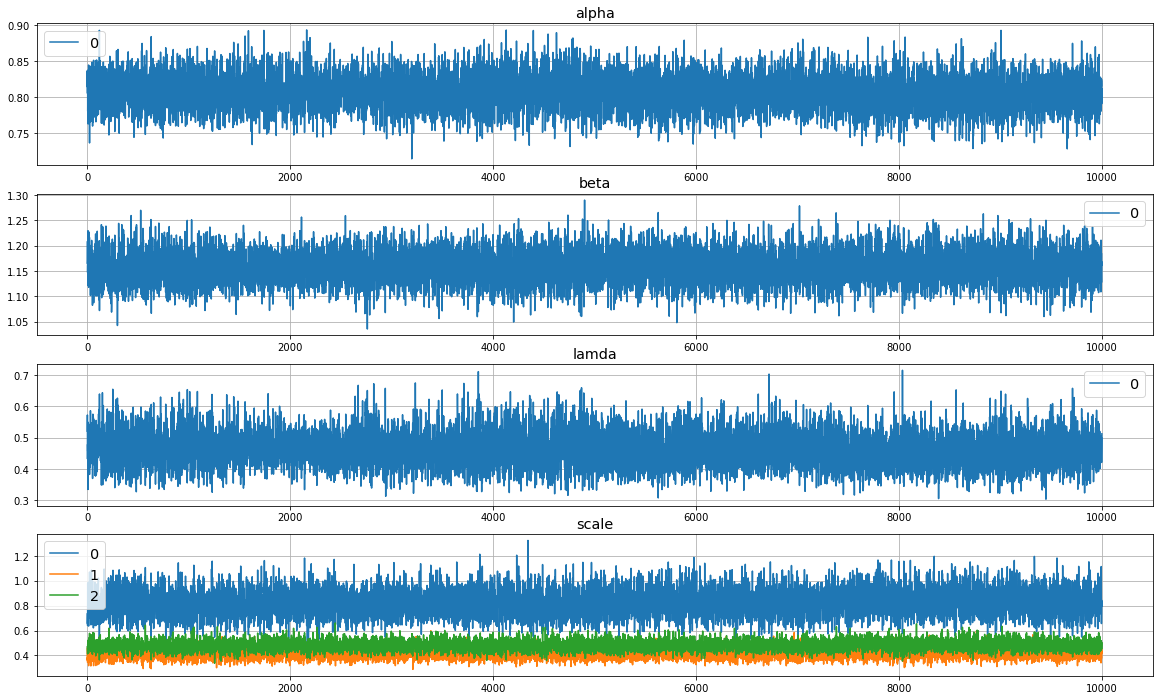

In [17]:
#Trace Plots for the Utility Parameters+Scale, mean parameters
pltsize(12,20)
fig,ax=plt.subplots(4)
frame(alpha).plot(ax=ax[0],title='alpha',grid=True)
frame(beta).plot(ax=ax[1],title='beta',grid=True)
frame(lamda).plot(ax=ax[2],title='lamda',grid=True)
frame(scale).plot(ax=ax[3],title='scale',grid=True)


<AxesSubplot:title={'center':'gama2'}>

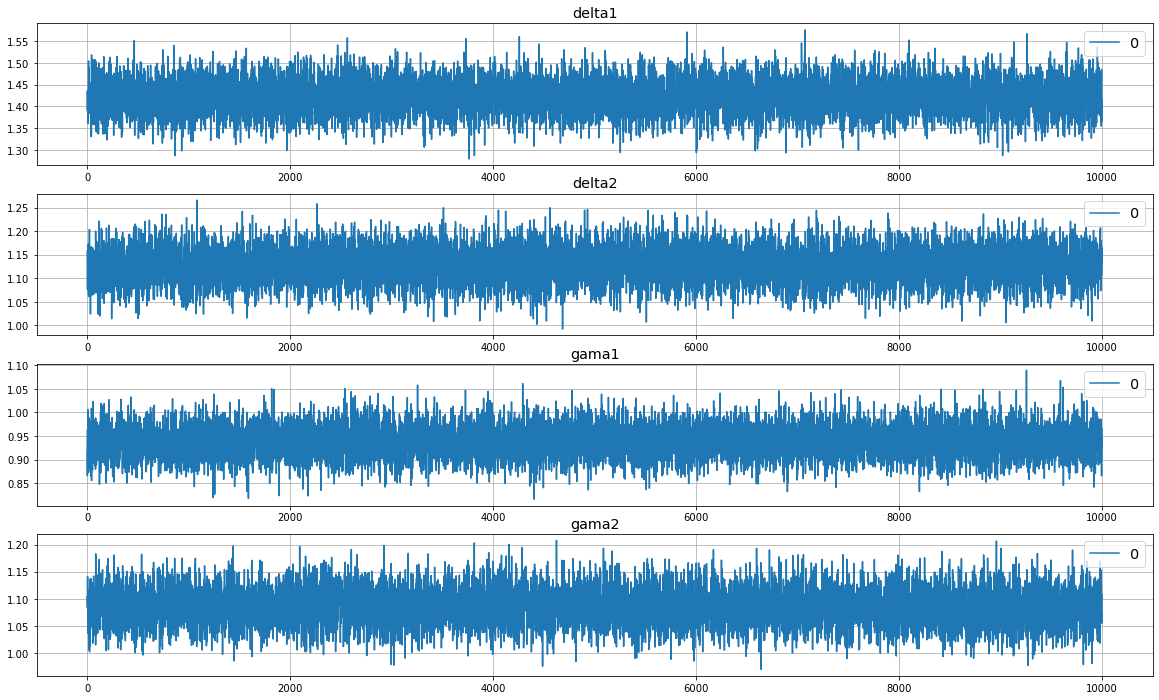

In [18]:
#Trace Plots for the probability transformations mean parameters
fig,ax=plt.subplots(4)
frame(delta1).plot(ax=ax[0],title='delta1',grid=True)
frame(delta2).plot(ax=ax[1],title='delta2',grid=True)
frame(gama1).plot(ax=ax[2],title='gama1',grid=True)
frame(gama2).plot(ax=ax[3],title='gama2',grid=True)

<AxesSubplot:title={'center':'scale'}, ylabel='Frequency'>

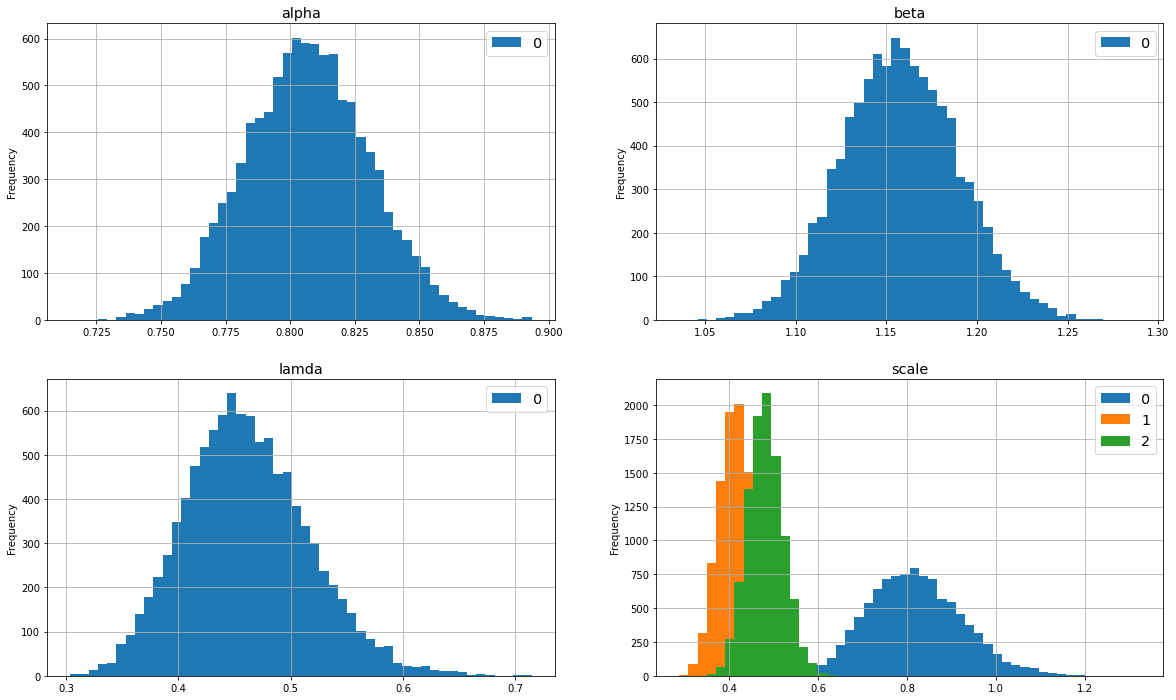

In [19]:
#Histogram for the Utility Parameters+Scale mean parameters
pltsize(12,20)
fig,ax=plt.subplots(2,2)
frame(alpha).plot(kind='hist',bins=50,ax=ax[0,0],title='alpha',grid=True)
frame(beta).plot(kind='hist',bins=50,ax=ax[0,1],title='beta',grid=True)
frame(lamda).plot(kind='hist',bins=50,ax=ax[1,0],title='lamda',grid=True)
frame(scale).plot(kind='hist',bins=50,ax=ax[1,1],title='scale',grid=True)

<AxesSubplot:title={'center':'gama1'}, ylabel='Frequency'>

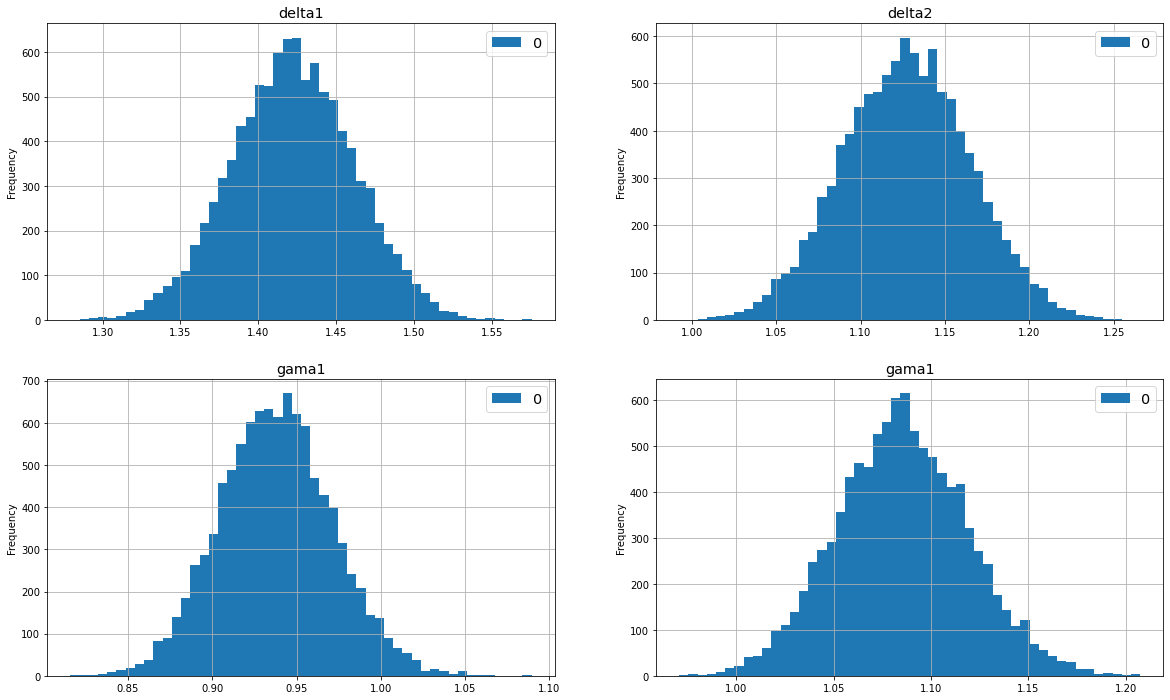

In [20]:
#Trace Plots for the probability transformations, mean parameters
pltsize(12,20)
fig,ax=plt.subplots(2,2)
frame(delta1).plot(kind='hist',bins=50,ax=ax[0,0],title='delta1',grid=True)
frame(delta2).plot(kind='hist',bins=50,ax=ax[0,1],title='delta2',grid=True)
frame(gama1).plot(kind='hist',bins=50,ax=ax[1,0],title='gama1',grid=True)
frame(gama2).plot(kind='hist',bins=50,ax=ax[1,1],title='gama1',grid=True)

In [21]:
#Collect the MCMC for the individual parameters
alphas,betas,lamdas,delta1s,delta2s,gama1s,gama2s,scales=[],[],[],[],[],[],[],[]
for i in range(143):    
    alphas+=[z['alpha_'][:,i].mean()]
    betas+=[z['beta_'][:,i].mean()]
    lamdas+=[z['lamda_'][:,i].mean()]
    delta1s+=[z['delta1_'][:,i].mean()]
    delta2s+=[z['delta2_'][:,i].mean()]
    gama1s+=[z['gama1_'][:,i].mean()]
    gama2s+=[z['gama2_'][:,i].mean()]
    scales+=[meanc(exp(z['scale_'][:,i]))]
scales=squeeze(scales)

<AxesSubplot:title={'center':'lamdas: individual means'}, ylabel='Frequency'>

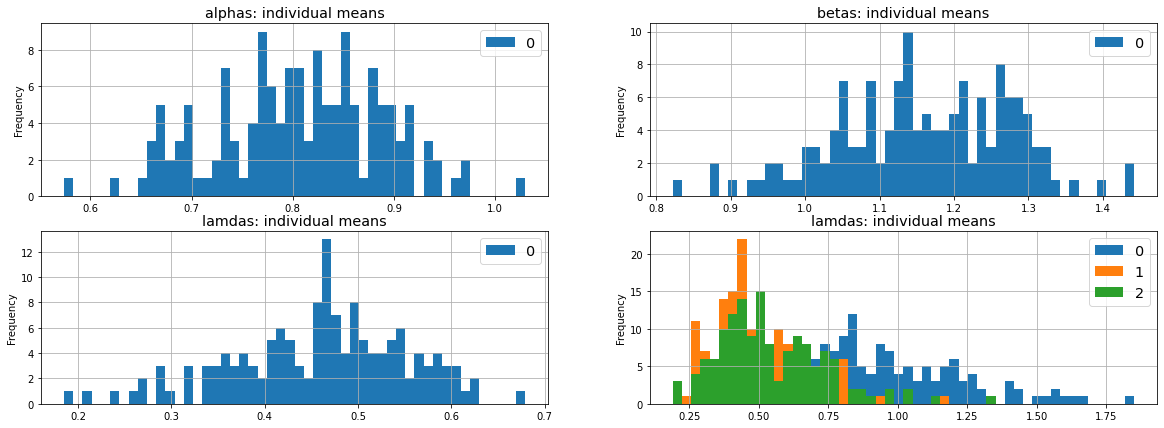

In [22]:
pltsize(7,20)
fig,ax=plt.subplots(2,2)
frame(alphas).plot(kind='hist',bins=50,ax=ax[0,0],title='alphas: individual means',grid=True)
frame(betas).plot(kind='hist',bins=50,ax=ax[0,1],title='betas: individual means',grid=True)
frame(lamdas).plot(kind='hist',bins=50,ax=ax[1,0],title='lamdas: individual means',grid=True)
frame(scales).plot(kind='hist',bins=50,ax=ax[1,1],title='lamdas: individual means',grid=True)

<AxesSubplot:title={'center':'gama2: individual means'}, ylabel='Frequency'>

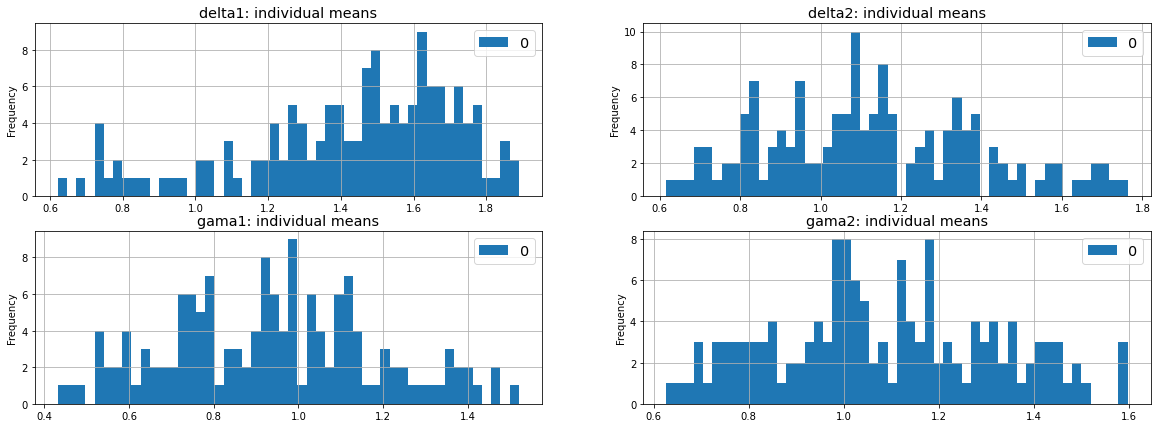

In [23]:
pltsize(7,20)
fig,ax=plt.subplots(2,2)
frame(delta1s).plot(kind='hist',bins=50,ax=ax[0,0],title='delta1: individual means',grid=True)
frame(delta2s).plot(kind='hist',bins=50,ax=ax[0,1],title='delta2: individual means',grid=True)
frame(gama1s).plot(kind='hist',bins=50,ax=ax[1,0],title='gama1: individual means',grid=True)
frame(gama2s).plot(kind='hist',bins=50,ax=ax[1,1],title='gama2: individual means',grid=True)

In [24]:
WAICf(z['log_lik'])

(          waic        elpd     p_waic1     p_waic2    maxloglik     se_waic
 0  15337.17692 -7668.58846  633.994818  712.451848 -7155.605101  115.480286,
 array([[-0.2749356 ],
        [-0.3511034 ],
        [-1.77863064],
        ...,
        [-0.71756473],
        [-0.69518529],
        [-0.68734449]]))